In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
X = np.zeros((1000,10))

for jj in range(0,10):
    if jj == 1:
        X[:,1] = np.random.normal(size = 1000)
    elif jj < 5:
        X[:,jj] = np.random.normal(size = 1000)
    elif jj < 8:
        X[:,jj] = np.random.choice([1,2,3,4], size=1000)
    else:
        continue
        
X[:,8] = X[:,1] + 3*X[:,2]
X[:,9] = X[:,2]*3*X[:,3]

y = X.sum(axis = 1)
y = y - np.min(y)


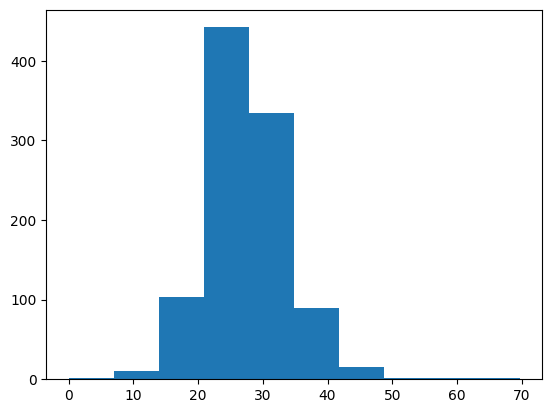

In [84]:
plt.hist(y)
plt.show()
        

In [85]:

def compute_ranks(array):
    # Get the array of indices that would sort the array
    sorted_indices = np.argsort(array)
    
    # Create an array to hold the ranks
    ranks = np.empty_like(sorted_indices)
    
    # Assign ranks based on the sorted indices
    ranks[sorted_indices] = np.arange(len(array))
    
    return ranks

y_rank = compute_ranks(y)


In [86]:
# comparison_y = pd.DataFrame(np.stack((y_pred, y_test), axis = 1), columns= ["y_pred","y_rank"])
# comparison_y

# # we can se that svm duplicates predicts!!!
# len(comparison_y["y_pred"].unique())
# len(comparison_y["y_rank"].unique())

,y_pred,y_rank
0,430,501
1,143,55
2,286,443
3,350,272
4,100,145
...,...,...
195,802,792
196,210,110
197,511,586
198,16,9


### Tensorflow model

In [87]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))
    
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")
    
def predict_ranking(model, docks):
    """
    Predict the ranking of docks using a trained RankNet model.
    
    Args:
        model (RankNet): A trained RankNet model.
        docks (np.array): A 2D numpy array where each row represents a dock's features.
    
    Returns:
        np.array: A NumPy array representing the predicted ranking of docks.
    """
    # Number of docks
    n_docks = docks.shape[0]
    
    # Generate all pairs of docks
    dock_indices = np.arange(n_docks)
    dock_pairs = np.array(list(combinations(dock_indices, 2)))
    
    # Prepare input arrays for model prediction
    xi = docks[dock_pairs[:, 0]]
    xj = docks[dock_pairs[:, 1]]
    
    # Predict pairwise preferences
    pairwise_preds = model.predict([xi, xj])
    
    # Initialize score array
    scores = np.zeros(n_docks)
    
    # Aggregate pairwise predictions into scores
    for (i, j), pred in zip(dock_pairs, pairwise_preds):
        if pred > 0.5:  # i is preferred over j
            scores[i] += 1
        else:           # j is preferred over i
            scores[j] += 1
    
    # Sort docks by their scores in descending order
    ranked_indices = np.argsort(-scores)  # Descending order
    
    return ranked_indices

In [88]:
nb_query = 100
query = np.array([i for i in range(nb_query) for x in range(10)])
doc_features = X.copy()
doc_scores = []

# Generate and store shuffled ranks for each query
for q in range(nb_query):
    query_idx = np.where(query == q)[0]
    ranks = compute_ranks(y[query_idx])
    doc_scores.append(ranks)

# Convert the list of arrays to a NumPy array
doc_scores = np.concatenate(doc_scores)
doc_scores

array([7, 0, 1, 8, 4, 2, 9, 6, 5, 3, 5, 2, 9, 7, 4, 1, 8, 3, 0, 6, 0, 1,
       6, 7, 5, 4, 2, 9, 3, 8, 6, 0, 2, 5, 4, 9, 1, 7, 8, 3, 8, 7, 3, 4,
       0, 9, 1, 2, 5, 6, 0, 7, 2, 9, 3, 1, 5, 6, 8, 4, 7, 0, 4, 6, 9, 8,
       5, 2, 1, 3, 7, 8, 6, 0, 9, 5, 2, 1, 4, 3, 2, 0, 9, 5, 8, 3, 1, 7,
       6, 4, 5, 0, 8, 7, 3, 2, 1, 9, 6, 4, 0, 4, 8, 6, 5, 9, 7, 2, 1, 3,
       5, 8, 4, 3, 1, 7, 0, 6, 2, 9, 3, 2, 1, 8, 4, 9, 7, 5, 0, 6, 5, 1,
       0, 8, 2, 4, 3, 7, 9, 6, 8, 2, 1, 0, 9, 3, 5, 6, 7, 4, 2, 0, 5, 8,
       1, 9, 6, 3, 7, 4, 9, 8, 7, 4, 6, 5, 1, 2, 0, 3, 5, 1, 3, 7, 9, 8,
       4, 0, 2, 6, 9, 8, 1, 4, 6, 7, 0, 2, 3, 5, 9, 4, 0, 1, 5, 3, 6, 7,
       2, 8, 7, 0, 4, 2, 8, 1, 9, 6, 3, 5, 8, 7, 3, 5, 2, 0, 4, 9, 1, 6,
       2, 0, 8, 9, 6, 5, 1, 3, 7, 4, 6, 4, 3, 9, 7, 1, 0, 5, 2, 8, 4, 1,
       6, 3, 0, 8, 9, 7, 2, 5, 7, 1, 8, 0, 9, 5, 6, 3, 2, 4, 8, 6, 7, 1,
       4, 3, 9, 5, 2, 0, 5, 6, 4, 9, 3, 7, 0, 8, 1, 2, 5, 2, 0, 3, 7, 4,
       6, 8, 9, 1, 8, 0, 7, 3, 2, 5, 9, 1, 4, 6, 2,

In [90]:

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
### for each query we must create all pairs
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    print(query_idx)
    # print(query_idx)
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i]) # features of first doc in pair
        xj.append(doc_features[j]) # features of second doc in pair
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)


[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]
[50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]
[100 101 102 103 104 105 106 107 108 109]
[110 111 112 113 114 115 116 117 118 119]
[120 121 122 123 124 125 126 127 128 129]
[130 131 132 133 134 135 136 137 138 139]
[140 141 142 143 144 145 146 147 148 149]
[150 151 152 153 154 155 156 157 158 159]
[160 161 162 163 164 165 166 167 168 169]
[170 171 172 173 174 175 176 177 178 179]
[180 181 182 183 184 185 186 187 188 189]
[190 191 192 193 194 195 196 197 198 199]
[200 201 202 203 204 205 206 207 208 209]
[210 211 212 213 214 215 216 217 218 219]
[220 221 222 223 224 225 226 227 228 229]
[230 231 232 233 234 235 236 237 238 239]
[240 241 242 243 244 245 246 247 248 249]
[250 251 252 253 254 255 256 257 258 259]
[260 261 262 263 2

In [91]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=20, batch_size=1, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 928us/step - loss: 0.2299 - val_loss: 0.0742
Epoch 2/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0525 - val_loss: 0.0393
Epoch 3/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0336 - val_loss: 0.0321
Epoch 4/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0336 - val_loss: 0.0329
Epoch 5/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0261 - val_loss: 0.0332
Epoch 6/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0226 - val_loss: 0.0361
Epoch 7/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0297 - val_loss: 0.0208
Epoch 8/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0173 - val_loss: 0.0238
Epoch 9/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0250 - val_loss: 0.0206
Epoch 10/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0182 - val_loss: 0.0176
Epoch 11/20
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0167 - val_loss: 0.0261
Epoch 12/20
3600/3600 ━━━━━━

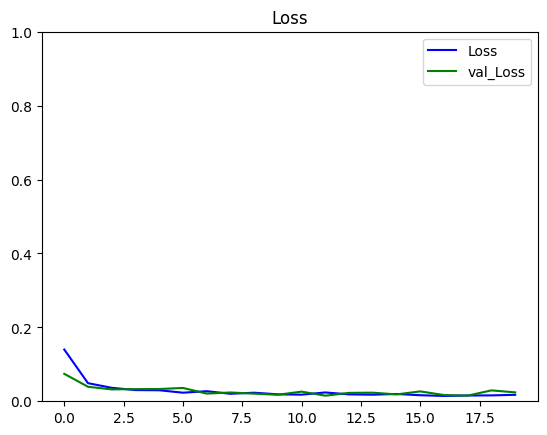

In [92]:
# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [93]:
import pandas as pd


docks = np.random.rand(10, 10) 

df_results = pd.DataFrame(columns = ["data", "pred"])

for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    ranking = predict_ranking(ranknet, doc_features[query_idx])
    comparison = np.stack((ranking, doc_scores[query_idx]), axis = 1)
    temp = pd.DataFrame(comparison, columns = ["data", "pred"])
    df_results = pd.concat((df_results, temp))

        

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━

In [95]:
df_results.to_excel("results.xlsx")